<b>Data Source:</b><br>
<b>Daily website visitors (time series regression), Bob Nau.</b><br>
<b>Retrived from</b> https://www.kaggle.com/datasets/bobnau/daily-website-visitors

# Import Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.ticker import MultipleLocator
import scipy.stats as stats
from scipy.stats import chi2
import pylab
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

In [5]:
raw_csv_data = pd.read_csv("daily-website-visitors.csv") 
df_comp=raw_csv_data.copy()
df_comp['date'] = pd.to_datetime(df_comp['Date'], dayfirst=True, utc=True)
df_comp.set_index('date', inplace=True)
duplicates = df_comp.index.duplicated()
df_comp = df_comp[~df_comp.index.duplicated(keep='first')]
df_comp = df_comp.asfreq('d')
df_comp = df_comp.ffill()
df_comp.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
date,,,,,,,,
2014-09-15 00:00:00+00:00,2,Monday,2,9/15/2014,3621,2528,2297,231
2014-09-16 00:00:00+00:00,3,Tuesday,3,9/16/2014,3698,2630,2352,278
2014-09-17 00:00:00+00:00,4,Wednesday,4,9/17/2014,3667,2614,2327,287
2014-09-18 00:00:00+00:00,5,Thursday,5,9/18/2014,3316,2366,2130,236
2014-09-19 00:00:00+00:00,6,Friday,6,9/19/2014,2815,1863,1622,241


In [6]:
df_comp.isnull().sum()

Row                  0
Day                  0
Day.Of.Week          0
Date                 0
Page.Loads           0
Unique.Visits        0
First.Time.Visits    0
Returning.Visits     0
dtype: int64

# Stationarity and Differencing

In [8]:
adf_result = adfuller(df_comp['Page.Loads'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] <= 0.05:
    print("✅ Series is stationary")
else:
    print("⚠️ Series is NOT stationary. Consider differencing.")

ADF Statistic: -4.754780031434472
p-value: 6.63195964503594e-05
✅ Series is stationary


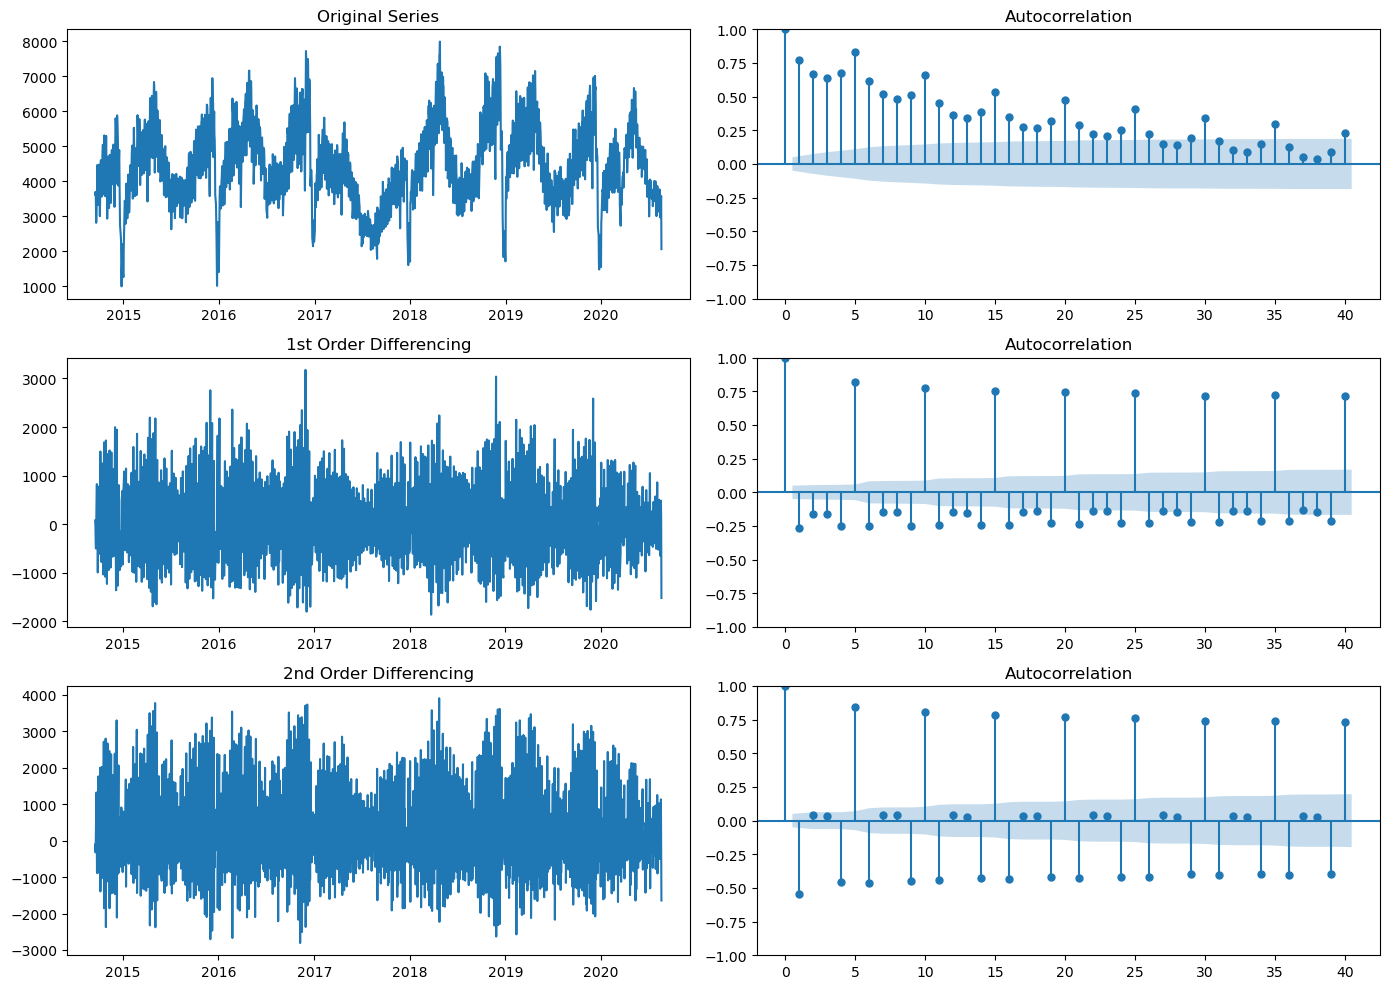

In [9]:
df_comp['Page.Loads'] = pd.to_numeric(df_comp['Page.Loads'], errors='coerce')
df_comp = df_comp.dropna(subset=['Page.Loads'])

# Create differenced series
temp_diff1 = df_comp['Page.Loads'].diff().dropna()
temp_diff2 = temp_diff1.diff().dropna()

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Plot original series
axes[0, 0].plot(df_comp['Page.Loads'])
axes[0, 0].set_title('Original Series')
plot_acf(df_comp['Page.Loads'].dropna(), ax=axes[0, 1], lags=min(40, len(df_comp) // 2))
axes[0, 1].set_title('Autocorrelation')

# 1st order differencing
axes[1, 0].plot(temp_diff1)
axes[1, 0].set_title('1st Order Differencing')
plot_acf(temp_diff1, ax=axes[1, 1], lags=min(40, len(temp_diff1) // 2))
axes[1, 1].set_title('Autocorrelation')

# 2nd order differencing
axes[2, 0].plot(temp_diff2)
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(temp_diff2, ax=axes[2, 1], lags=min(40, len(temp_diff2) // 2))
axes[2, 1].set_title('Autocorrelation')

plt.tight_layout()
plt.show()


## We dont need differencing therefore sarmax would be better model

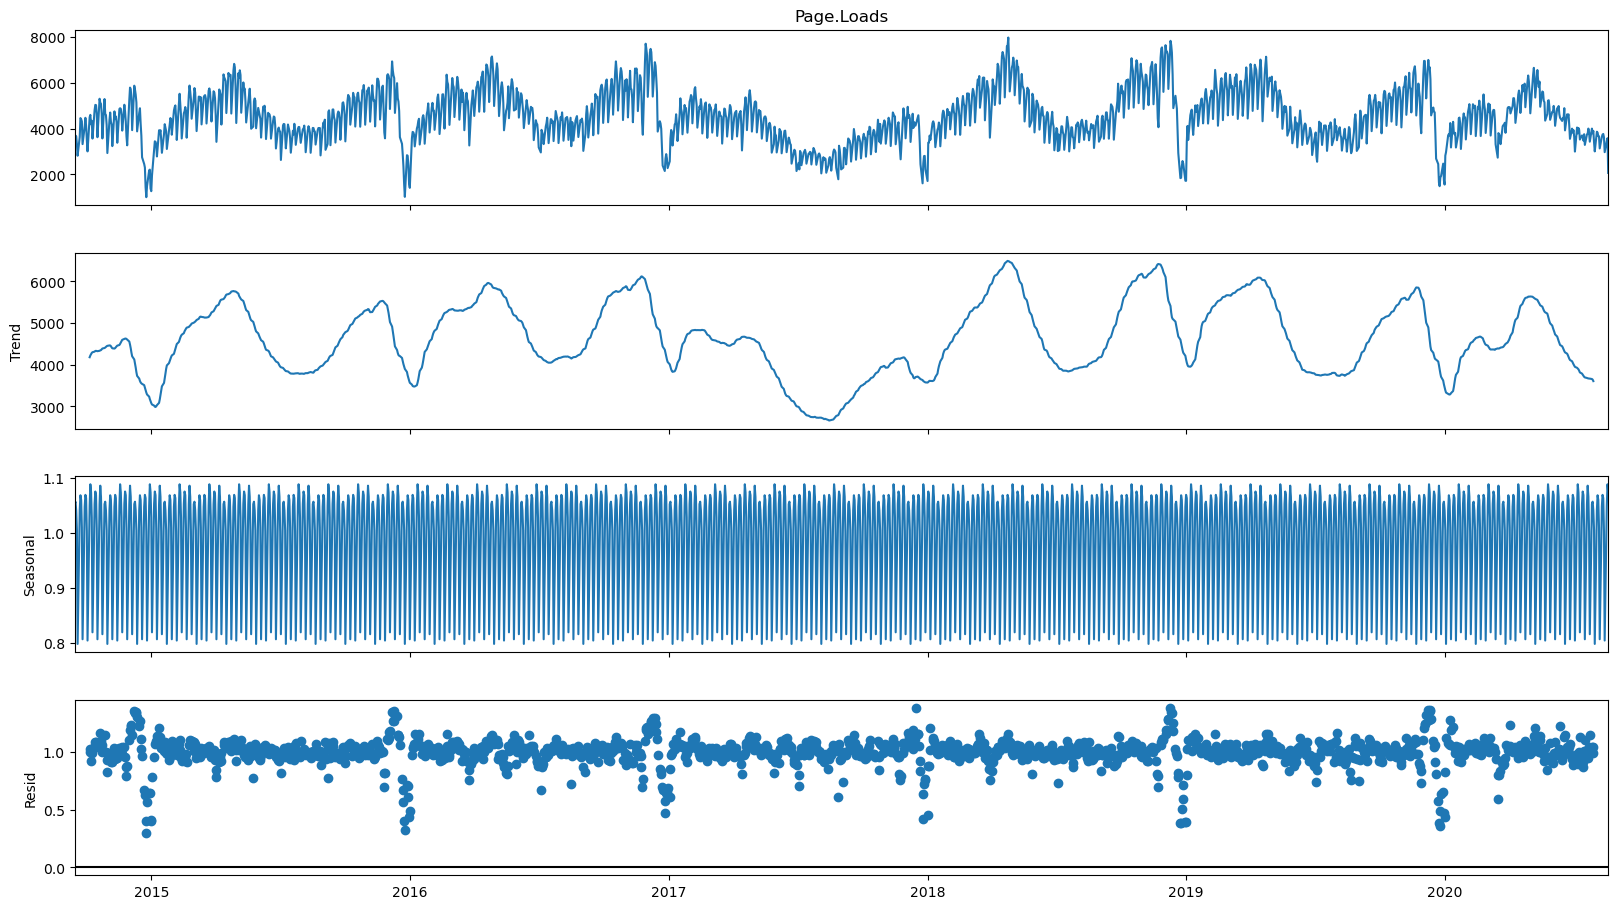

In [11]:
decomposition = seasonal_decompose(df_comp['Page.Loads'],
                                  model = 'mull',
                                  period = 30)
fig = decomposition.plot()
fig.set_size_inches(18, 10)
plt.show()

# Train split data

In [13]:
size = int(len(df_comp)*0.95)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

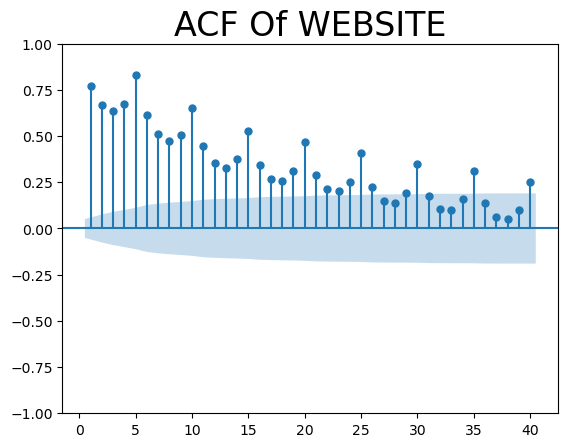

In [14]:
sgt.plot_acf(df['Page.Loads'], zero = False, lags = 40)
plt.title('ACF Of WEBSITE',size = 24)
plt.show()

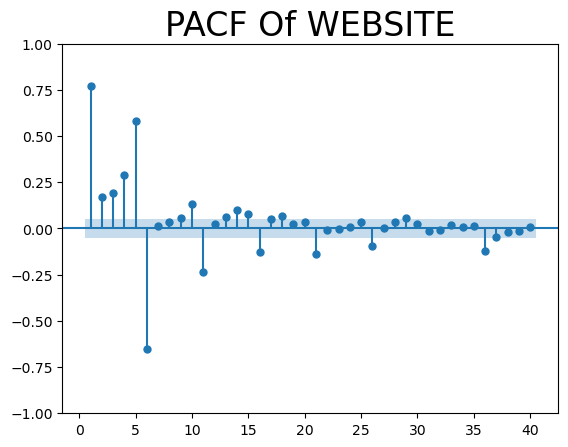

In [15]:
sgt.plot_pacf(df['Page.Loads'], zero = False, lags = 40)
plt.title('PACF Of WEBSITE',size = 24)
plt.show()

In [27]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# === Define target and exogenous features ===
y_train = df['Page.Loads']
X_train = df[['Day.Of.Week', 'Unique.Visits','First.Time.Visits','Returning.Visits']]
y_test = df_test['Page.Loads']
X_test = df_test[['Day.Of.Week', 'Unique.Visits','First.Time.Visits','Returning.Visits']]

model = auto_arima(y_train,
                   exogenous=X_train,
                   seasonal=True,
                   m=30,  # Assuming monthly seasonality
                   stepwise=True,
                   trace=True,
                   suppress_warnings=True,
                   error_action='ignore')

# === Model Summary ===
print(model.summary())

# === Forecast ===
predictions_sarimax = model.predict(n_periods=len(y_test), exogenous=X_test)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=inf, Time=73.72 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=24973.488, Time=0.18 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=22653.434, Time=40.32 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=23789.937, Time=19.05 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=29079.739, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[30] intercept   : AIC=23636.948, Time=0.32 sec
 ARIMA(1,0,0)(2,0,0)[30] intercept   : AIC=inf, Time=91.95 sec
 ARIMA(1,0,0)(1,0,1)[30] intercept   : AIC=23052.945, Time=46.35 sec
 ARIMA(1,0,0)(0,0,1)[30] intercept   : AIC=23127.736, Time=23.55 sec
 ARIMA(1,0,0)(2,0,1)[30] intercept   : AIC=inf, Time=106.72 sec
 ARIMA(0,0,0)(1,0,0)[30] intercept   : AIC=24964.680, Time=2.00 sec
 ARIMA(2,0,0)(1,0,0)[30] intercept   : AIC=22629.969, Time=14.48 sec
 ARIMA(2,0,0)(0,0,0)[30] intercept   : AIC=23594.517, Time=0.27 sec
 ARIMA(2,0,0)(2,0,0)[30] intercept   : AIC=22889.476, Time=38.24 sec
 ARIMA(2,0,0)

In [28]:
predictions_sarimax

2020-05-04 00:00:00+00:00    5794.628316
2020-05-05 00:00:00+00:00    5661.994067
2020-05-06 00:00:00+00:00    5576.152456
2020-05-07 00:00:00+00:00    5649.644996
2020-05-08 00:00:00+00:00    4772.664581
                                ...     
2020-08-13 00:00:00+00:00    5337.257876
2020-08-14 00:00:00+00:00    4623.969877
2020-08-17 00:00:00+00:00    5431.423176
2020-08-18 00:00:00+00:00    5628.305586
2020-08-19 00:00:00+00:00    5566.215293
Freq: B, Length: 78, dtype: float64

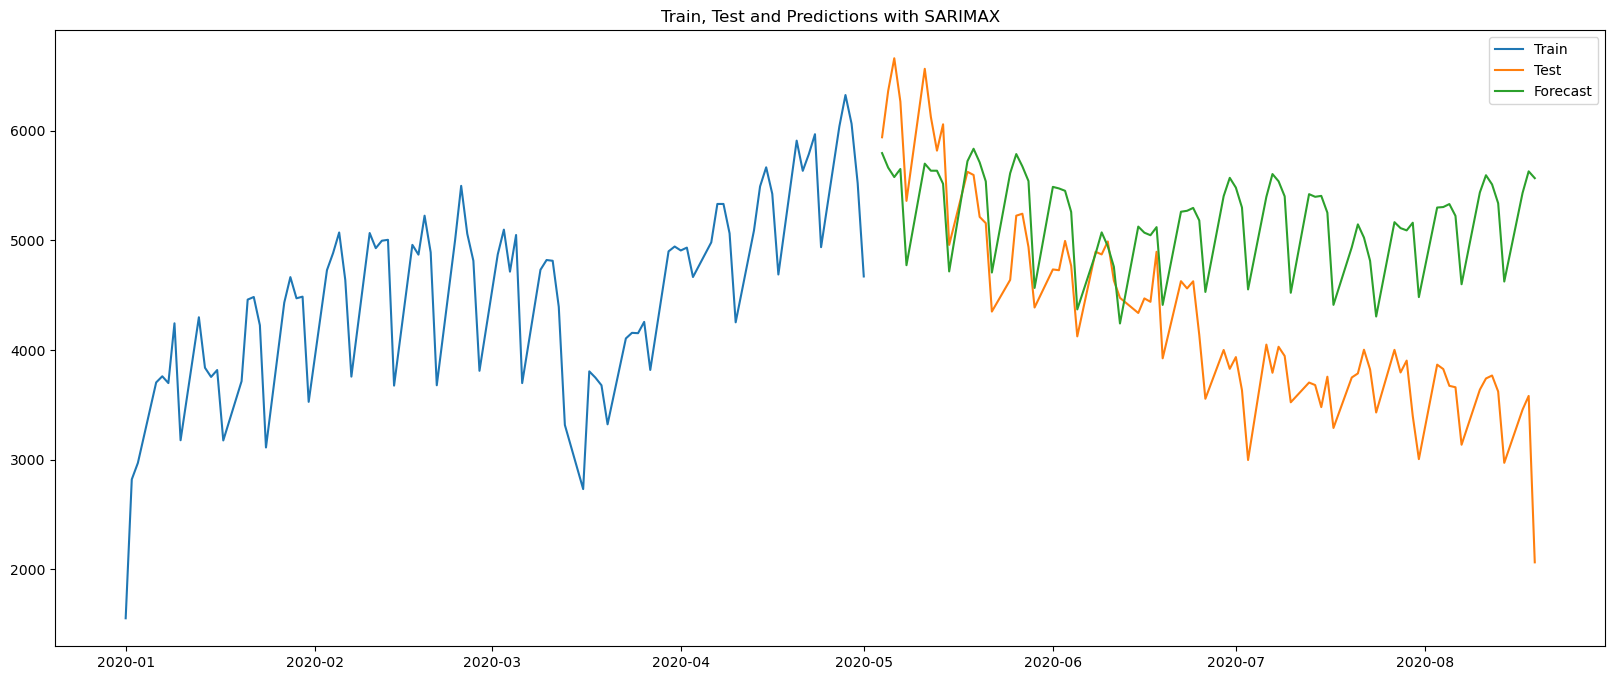

The MAE is 1013.27
The RMSE is 1199.70
The MAPE is 27.06 %


In [39]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (20,8))
  # Plot the train, test, and forecast data
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = root_mean_squared_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

# Model assessment
model_assessment(df['Page.Loads']['2020':], df_test['Page.Loads'], predictions_sarimax, "SARIMAX")

The forecast (green) reflects the clear seasonality in the data, indicating that the model has successfully captured periodic fluctuations.
At the start of the forecast period, predictions align quite well with the actual test data. This suggests a well-fitted model during short-term forecasting.

As we move further into the test period, the gap between the forecast and the actual values increases. This is expected in time series models, as uncertainty accumulates over longer horizons.

So, to concuted The SARMAX model performs reasonably well, especially in the short term, capturing seasonality and general trends. However, forecast accuracy decreases over longer periods, as expected. With an MAE of ~1013, the model is acceptable but could benefit from further refinement if higher precision is required—especially for critical forecasting tasks in financial or resource planning contexts.

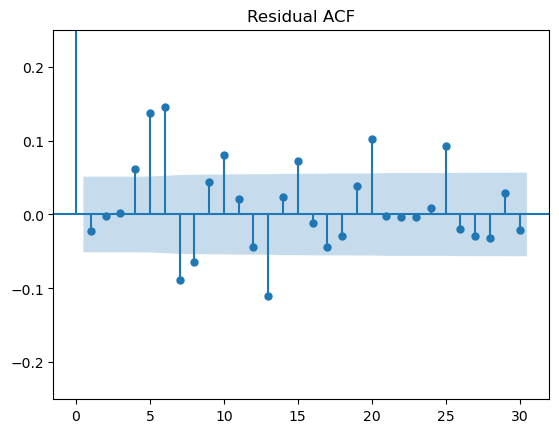

In [46]:
import statsmodels.api as sm
residuals = pd.Series(model.resid())
sm.graphics.tsa.plot_acf(residuals, lags=30)
plt.title("Residual ACF")
plt.ylim(-0.25,0.25)
plt.show()

In [48]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(model.resid(), lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,95.876525,3.632260e-16


Although the SARIMAX model's forecast appears visually accurate—especially in the short term—further statistical diagnostics reveal that the model is not yet fully adequate.

    The ACF plot of residuals shows significant autocorrelation, particularly at lag 1, 5, 6, 7, 8, 10.

    The Ljung-Box test yields an extremely low p-value (3.63e-16), indicating that the residuals are not white noise and that the model has failed to capture all underlying patterns in the data.

In summary, while the visual forecast may seem acceptable, statistical evaluation suggests that the model requires improvement. Future steps may include:

    Tuning the SARIMAX parameters,

    Introducing more relevant exogenous variables,

    Or even exploring alternative machine learning models such as Random Forest, XGBoost, or LSTM for enhanced long-term forecasting performance.